Have you canceled any hotel after booking ? Why did you cancel ? In which category did you fall ?

Problem Statement: A large number of hotels faces cancellations after booking within the near checkin. To predict, whether they need to prepare for any implementation to fill out the cancelled rooms, using various machine learning algorithms.

Hotel booking cancellations pose significant challenges for both customers and hotel management. The ability to predict these cancellations accurately can revolutionize resource planning, revenue management, and customer satisfaction within the hospitality industry. Efficiently predicting and managing hotel room occupancy rates is crucial for maximizing profits while ensuring customer satisfaction. Understanding the factors influencing booking patterns and guest preferences is essential for hoteliers to make informed decisions regarding pricing, promotions, and inventory management.

Motivation: 

Competitive Advantage: Understanding market trends and customer preferences can provide a competitive edge by offering tailored services and pricing.
Improve Operations: Predictive analytics can help hotels manage inventory more effectively, preventing overbooking or underutilization of rooms.
Revenue Management: Accurate predictions help in maximizing revenue by allowing hotels to resell canceled rooms or offer them to waitlisted customers, preventing revenue loss.
Optimizing Resource Utilization: Anticipating cancellations enables hotels to optimize resource allocation, such as staff scheduling, room inventory management, and service provision, reducing operational costs.
Data-Driven Insights: Hotel booking data, including historical bookings, customer profiles, booking channels, and reservation timing, contains valuable insights. Utilizing this data to predict cancellations can improve decision-making.

In [1]:
import pandas as pd
import numpy as np
import sqlite3
from sqlite3 import Error
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
def create_connection(db_file, delete_db=False):
  import os
  if delete_db and os.path.exists(db_file):
    os.remove(db_file)

  conn = None
  try:
    conn = sqlite3.connect(db_file)
    conn.execute("PRAGMA foreign_keys = 1")
  except Error as e:
    print(e)

  return conn

def create_table(conn, create_table_sql, drop_table_name=None):
    
  if drop_table_name:
    try:
      c = conn.cursor()
      c.execute("""drop table if exists %s""" % (drop_table_name))
    except Error as e:
      print(e)
  
  try:
    c = conn.cursor()
    c.execute(create_table_sql)
  except Error as e:
    print(e)
        
def execute_sql_statement(sql_statement, conn):
  cur = conn.cursor()
  cur.execute(sql_statement)
  rows = cur.fetchall()
  return rows


In [3]:
data = list()
with open('hotel_booking.csv', 'r') as f:
    lines = f.readlines()
    data = [tuple(i.strip().split(',')) for i in lines[1:]]
f.close()

In [4]:
conn_norm = create_connection('hotel_booking_norm.db')
cur = conn_norm.cursor()

create_table_sql = """
create table if not exists person (
    [name] text, 
    [email] text not null primary key, 
    [country] text,
    [phone_number] text, 
    [credit_card] integer
    );
    """

create_table(conn_norm, create_table_sql, 'person')
person_data = [(line[-4:] + (line[13],)) for line in data]
conn_norm.executemany('insert or ignore into person (name, email, phone_number, credit_card, country) values(?,?,?,?,?)', person_data)


create_table_sql = """create table if not exists hotel (
    [hotel] text not null Primary key
    );"""
create_table(conn_norm, create_table_sql, 'hotel')
hotel_data = [line[0] for line in data]
hotel_data = set(hotel_data)
h_data = [(i,) for i in hotel_data]
conn_norm.executemany('insert or ignore into hotel (hotel) values(?)', h_data)


create_table_sql = """create table if not exists booking (
    [hotel] text,
    [is_canceled] integer, 
    [lead_time] integer, 
    [arrival_date] text, 
    [arrival_date_week_number] integer, 
    [stays_in_weekend_nights] integer, 
    [stays_in_week_nights] integer, 
    [adults] integer, [children] double, [babies] integer, 
    [meal] text,
    [market_segment] text, 
    [distribution_channel] text, 
    [is_repeated_guest] text, [previous_cancellations] integer, [previous_bookings_not_canceled] integer, 
    [reserved_room_type] integer, 
    [assigned_room_type] integer, 
    [booking_changes] integer, 
    [deposit_type] text, 
    [agent] integer,
    [company] text, 
    [days_in_waiting_list] integer,
    [customer_type] text, [adr] double, 
    [required_car_parking_spaces] integer, 
    [total_of_special_requests] integer, 
    [reservation_status] text, 
    [reservation_status_date] text, 
    [email] text, 
    foreign key (email) references person(email), 
    foreign key (hotel) references hotel(hotel) 
    );"""


create_table(conn_norm, create_table_sql, 'booking')
month = {"January" : '01' , "February" : '02', "March" : '03', "April" : '04',  "May" : '05' ,  "June" : '06', "July" : '07', "August" : '08' , "September" : '09' ,  "October" : '10', "November" : '11', "December" : '12'}
booking_data = [line[:-4] + (line[-3],) for line in data]
for i in range(len(booking_data)):
    booking_data[i] = list(booking_data[i])
    if len(booking_data[i][6]) == 1:
        booking_data[i][6] = '0' + booking_data[i][6]
    booking_data[i][3] = f'{booking_data[i][3]}-{month[booking_data[i][4]]}-{booking_data[i][6]}'
    del booking_data[i][4]
    del booking_data[i][6]
    del booking_data[i][13]
    booking_data[i] = tuple(booking_data[i])

sql= """insert or ignore into booking (hotel, is_canceled, lead_time, arrival_date, arrival_date_week_number, stays_in_weekend_nights, stays_in_week_nights, 
adults, children, babies, meal, market_segment, distribution_channel, is_repeated_guest, previous_cancellations, 
previous_bookings_not_canceled, reserved_room_type, assigned_room_type, booking_changes, deposit_type, agent, company, 
days_in_waiting_list, customer_type, adr, required_car_parking_spaces, total_of_special_requests, reservation_status, reservation_status_date, 
email) values(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)"""
conn_norm.executemany(sql, booking_data)

conn_norm.commit()
conn_norm.close()

In [5]:
conn_norm = create_connection('hotel_booking_norm.db')
sql1 = 'select * from booking'
df = pd.read_sql_query(sql1, conn_norm)
conn_norm.commit()
conn_norm.close()
df.head()

,hotel,is_canceled,lead_time,arrival_date,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,email
0,Resort Hotel,0,342,2015-07-01,27,1,0,2,0.0,0,...,,,0,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest.Barnes31@outlook.com
1,Resort Hotel,0,737,2015-07-01,27,1,0,2,0.0,0,...,,,0,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea_Baker94@aol.com
2,Resort Hotel,0,7,2015-07-01,27,1,1,1,0.0,0,...,,,0,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca_Parker@comcast.net
3,Resort Hotel,0,13,2015-07-01,27,1,1,1,0.0,0,...,304,,0,Transient,75.0,0,0,Check-Out,2015-07-02,Laura_M@gmail.com
4,Resort Hotel,0,14,2015-07-01,27,1,2,2,0.0,0,...,240,,0,Transient,98.0,0,1,Check-Out,2015-07-03,LHines@verizon.com


In [6]:
conn_norm = create_connection('hotel_booking_norm.db')
cur = conn_norm.cursor()
sql = '''
select hotel, is_canceled, count(*) as total_bookings
from booking
group by hotel, is_canceled
order by total_bookings;
'''
res = pd.read_sql_query(sql, conn_norm)
conn_norm.commit()
conn_norm.close()
fig = px.bar(res, x='is_canceled', y='total_bookings', color='hotel', barmode='group', title='Total Bookings by Hotel')
fig.show()

Total Bookings by hotel wrt is_canceled = False or True and either Resort Hotel or City hotel
is_canceled = 0 (False) 

Displays the total bookings by hotel, distinguishing between canceled and non-canceled bookings. Also, visualizes the count of bookings for each hotel, segmented by whether they were canceled or not.

non-canceled bookings of Resort Hotel are 72 % of total bookings. So canceled bookings are of 28% in Resort Hotel
non-canceled bookings of City Hotel are 58 % of total bookings. So canceled bookings are of 42% in Resort Hotel

In [7]:
conn_norm = create_connection('hotel_booking_norm.db')
cur = conn_norm.cursor()

sql = """
select strftime('%Y', b.arrival_date) as Year, 
h.hotel,
b.is_canceled,
sum(b.stays_in_weekend_nights) as weekend, 
sum(b.stays_in_week_nights) as week, count(*) as total_bookings
from booking b
join hotel h on b.hotel = h.hotel
group by Year, h.hotel, b.is_canceled
limit 50;
"""

res = pd.read_sql_query(sql, conn_norm)
conn_norm.commit()
conn_norm.close()
print(res)


    Year         hotel  is_canceled  weekend   week  total_bookings
0   2015    City Hotel            0   120390  15454            7678
1   2015    City Hotel            1    94429  11670            6004
2   2015  Resort Hotel            0    98125  19768            6176
3   2015  Resort Hotel            1    31436   7246            2138
4   2016    City Hotel            0   361741  47773           22733
5   2016    City Hotel            1   244117  35621           15407
6   2016  Resort Hotel            0   217396  39238           13637
7   2016  Resort Hotel            1    79017  15892            4930
8   2017    City Hotel            0   249132  34912           15817
9   2017    City Hotel            1   182544  27744           11691
10  2017  Resort Hotel            0   143810  28068            9125
11  2017  Resort Hotel            1    64015  15125            4054


The table summarizes hotel booking statistics across different years, hotel types, and cancellation status, including bookings on weekends and weekdays, providing insights into the overall booking trends.

In [8]:
conn_norm = create_connection('hotel_booking_norm.db')
cur = conn_norm.cursor()
sql = '''
select reservation_status, is_repeated_guest, count(*) as total_bookings
from booking
group by reservation_status, is_repeated_guest
order by total_bookings desc;
'''
res = pd.read_sql_query(sql, conn_norm)
conn_norm.commit()
conn_norm.close()

fig = px.bar(res, x='reservation_status', y='total_bookings', color='is_repeated_guest', barmode='group', title='Reservation status of Repeated Guests')
fig.show()

The total bookings grouped by reservation status and whether the guest is repeated.

non-repeated guest in check-out are 95% of total bookings
non-repeated guest in canceled are 98% of total bookings
non-repeated guest in no-show are 100% of total bookings

In [9]:
conn_norm = create_connection('hotel_booking_norm.db')
cur = conn_norm.cursor()

sql = """
SELECT
    CASE
        WHEN strftime('%m', arrival_date) = '01' THEN 'January'
        WHEN strftime('%m', arrival_date) = '02' THEN 'February'
        WHEN strftime('%m', arrival_date) = '03' THEN 'March'
        WHEN strftime('%m', arrival_date) = '04' THEN 'April'
        WHEN strftime('%m', arrival_date) = '05' THEN 'May'
        WHEN strftime('%m', arrival_date) = '06' THEN 'June'
        WHEN strftime('%m', arrival_date) = '07' THEN 'July'
        WHEN strftime('%m', arrival_date) = '08' THEN 'August'
        WHEN strftime('%m', arrival_date) = '09' THEN 'September'
        WHEN strftime('%m', arrival_date) = '10' THEN 'October'
        WHEN strftime('%m', arrival_date) = '11' THEN 'November'
        WHEN strftime('%m', arrival_date) = '12' THEN 'December'
    END Month,
    is_canceled, COUNT(*) as total_bookings
FROM
    booking
GROUP BY
    Month, is_canceled
Order by arrival_date;
"""

res = pd.read_sql_query(sql, conn_norm)
conn_norm.commit()
conn_norm.close()
# print(res)
fig = px.line(res, x='Month', y='total_bookings', color='is_canceled', title='Cancellations by Month')
fig.show()


hotel booking data grouped by month, showcasing cancellations over time 

In July non-canceled bookings are 62% of total bookings
In August non-canceled bookings are 62% of total bookings
In September non-canceled bookings are 60% of total bookings
In October non-canceled bookings are 61% of total bookings
In November non-canceled bookings are 68% of total bookings
In December non-canceled bookings are 65% of total bookings
In January non-canceled bookings are 69% of total bookings
In February non-canceled bookings are 66% of total bookings
In March non-canceled bookings are 67% of total bookings
In April non-canceled bookings are 59% of total bookings
In May non-canceled bookings are 60% of total bookings
In June non-canceled bookings are 58% of total bookings

In [10]:
conn_norm = create_connection('hotel_booking_norm.db')
cur = conn_norm.cursor()

sql = """
    select p.country, b.hotel, round(sum(adr), 2) as adr, count(*) as total_bookings
    from booking b
    join person p on b.email = p.email
    group by country, hotel
    order by adr desc
    limit 20;
"""

res = pd.read_sql_query(sql, conn_norm)
conn_norm.commit()
conn_norm.close()
# print(res)
fig = px.bar(res, x='country', y='adr', color='hotel', barmode='group', title='Total Revenue by Countries')
fig.show()


Analyzing top revenue-generating countries for hotels

In [11]:
conn_norm = create_connection('hotel_booking_norm.db')
cur = conn_norm.cursor()

sql = """
SELECT
    CASE
        WHEN strftime('%m', arrival_date) = '01' THEN 'January'
        WHEN strftime('%m', arrival_date) = '02' THEN 'February'
        WHEN strftime('%m', arrival_date) = '03' THEN 'March'
        WHEN strftime('%m', arrival_date) = '04' THEN 'April'
        WHEN strftime('%m', arrival_date) = '05' THEN 'May'
        WHEN strftime('%m', arrival_date) = '06' THEN 'June'
        WHEN strftime('%m', arrival_date) = '07' THEN 'July'
        WHEN strftime('%m', arrival_date) = '08' THEN 'August'
        WHEN strftime('%m', arrival_date) = '09' THEN 'September'
        WHEN strftime('%m', arrival_date) = '10' THEN 'October'
        WHEN strftime('%m', arrival_date) = '11' THEN 'November'
        WHEN strftime('%m', arrival_date) = '12' THEN 'December'
    END Month,
    hotel,
    round(avg(adr), 2) as ADR
FROM
    booking
GROUP BY
    Month, hotel
order by arrival_date;
"""

res = pd.read_sql_query(sql, conn_norm)
conn_norm.commit()
conn_norm.close()
# print(res)
fig = px.line(res, x='Month', y='ADR', color='hotel', title='Average Daily Rates by Month')
fig.show()

Visualizing average daily rate per month

In [12]:
conn_norm = create_connection('hotel_booking_norm.db')
cur = conn_norm.cursor()

sql = """
select b.adr, b.arrival_date, b.hotel, p.name, p.email, p.country
from booking b
join person p on b.email = p.email
where b.is_canceled != '1'
order by b.adr desc
limit 5;
"""

res = pd.read_sql_query(sql, conn_norm)
conn_norm.commit()
conn_norm.close()
res.head()


,adr,arrival_date,hotel,name,email,country
0,510.00,2017-05-09,City Hotel,Jesus Mason,Jesus.Mason@aol.com,ITA
1,508.00,2015-07-15,Resort Hotel,Samuel Hammond,Samuel_Hammond@yahoo.com,PRT
2,451.50,2016-12-31,City Hotel,Jessica Morris,Jessica.Morris@yahoo.com,PRT
3,426.25,2017-08-01,Resort Hotel,Molly Daniel,Molly.Daniel74@protonmail.com,PRT
4,402.00,2017-08-17,Resort Hotel,Geoffrey Leon,Leon.Geoffrey@gmail.com,ESP


Retrieving top bookings with the highest average daily rate (ADR) along with associated customer details.

In [13]:
conn_norm = create_connection('hotel_booking_norm.db')
cur = conn_norm.cursor()

sql = """
SELECT
    CASE
        WHEN strftime('%m', arrival_date) = '01' THEN 'January'
        WHEN strftime('%m', arrival_date) = '02' THEN 'February'
        WHEN strftime('%m', arrival_date) = '03' THEN 'March'
        WHEN strftime('%m', arrival_date) = '04' THEN 'April'
        WHEN strftime('%m', arrival_date) = '05' THEN 'May'
        WHEN strftime('%m', arrival_date) = '06' THEN 'June'
        WHEN strftime('%m', arrival_date) = '07' THEN 'July'
        WHEN strftime('%m', arrival_date) = '08' THEN 'August'
        WHEN strftime('%m', arrival_date) = '09' THEN 'September'
        WHEN strftime('%m', arrival_date) = '10' THEN 'October'
        WHEN strftime('%m', arrival_date) = '11' THEN 'November'
        WHEN strftime('%m', arrival_date) = '12' THEN 'December'
    END Month,
    round(avg(lead_time), 2) as lead_time,
    is_canceled
FROM
    booking
GROUP BY
    Month
order by lead_time desc;
"""

res = pd.read_sql_query(sql, conn_norm)
conn_norm.commit()
conn_norm.close()
# print(res)
fig = px.pie(res, values='lead_time', names='Month', title='Elapsed days between booking date and arrival date')
fig_new = go.Figure(fig)
fig_new.update_traces(hoverinfo='percent', textinfo='value')
fig_new.show()


Analyzing the lead time between booking and arrival date for different months.

According to the results of the analysis, a customer must make reservations at least 136 days in advance of their intended September arrival date.

In [14]:
conn_norm = create_connection('hotel_booking_norm.db')
sql = '''select is_canceled, lead_time, arrival_date_week_number, stays_in_weekend_nights, stays_in_week_nights, 
adults, previous_cancellations, 
previous_bookings_not_canceled, booking_changes, days_in_waiting_list,  adr, required_car_parking_spaces,
total_of_special_requests from booking'''
df1 = pd.read_sql_query(sql, conn_norm)
conn_norm.commit()
conn_norm.close()
y = df1['is_canceled']
x = df1.drop('is_canceled', axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=1,test_size=0.2)

In [15]:
def model_metrics(y_test, pred):
    # tn, fp, fn, tp = cf.flatten()

    # precision = tp / (tp + fp)
    # recall = tp / (tp + fn)
    # sensitivity = tp / (tp + fn)
    # specificity = tn / (tn + fp)
    res = dict()
    final = dict()
    cc = classification_report(y_test, pred, output_dict=True)

    precision = cc['0']['precision']
    f1_score = cc['0']['f1-score']
    recall = cc['0']['recall']

    pi = 2 / ((1 / recall) + (1 / precision))
    specificity = (f1_score * (1 - pi)) / (f1_score + pi * (1 - f1_score))
    sensitivity = pi * recall / (pi * recall + (1 - pi) * precision)
    res['precision'] = round(precision, 2)
    res['f1-score'] = round(f1_score, 2)
    res['recall'] = round(recall, 2)
    res['sensitivity'] = round(sensitivity, 2)
    res['specificity'] = round(specificity, 2)
    final['0'] = res

    del res
    res = dict()

    precision = cc['1']['precision']
    f1_score = cc['1']['f1-score']
    recall = cc['1']['recall']

    pi = 2 / ((1 / recall) + (1 / precision))
    specificity = (f1_score * (1 - pi)) / (f1_score + pi * (1 - f1_score))
    sensitivity = pi * recall / (pi * recall + (1 - pi) * precision)
    res['precision'] = round(precision, 2)
    res['f1-score'] = round(f1_score, 2)
    res['recall'] = round(recall, 2)
    res['sensitivity'] = round(sensitivity, 2)
    res['specificity'] = round(specificity, 2)
    final['1'] = res

    final_metrics = pd.DataFrame(final)

    return final_metrics.T

Test Accuracy : 73.49%
   precision  f1-score  recall  sensitivity  specificity
0       0.75      0.81    0.87         0.83         0.16
1       0.70      0.58    0.49         0.49         0.30


<Axes: >

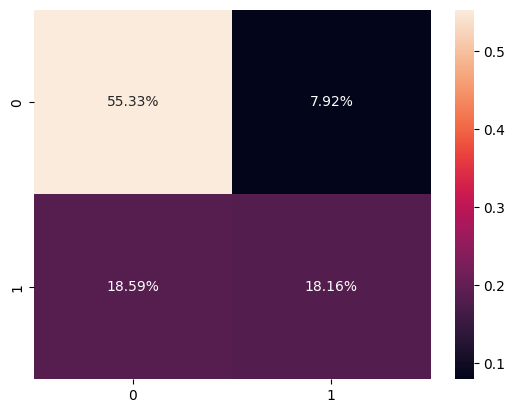

In [16]:
model_log = LogisticRegression(max_iter=1600)
model_log.fit(x_train, y_train)
pred_log = model_log.predict(x_test)
acc_log= accuracy_score(pred_log, y_test)
print(f'Test Accuracy : {acc_log*100:.2f}%')
print(model_metrics(y_test, pred_log))
cf_matrix_log = confusion_matrix(y_test, pred_log)
sns.heatmap(cf_matrix_log/np.sum(cf_matrix_log), annot=True, fmt= '0.2%')


Test Accuracy : 80.23%
   precision  f1-score  recall  sensitivity  specificity
0       0.85      0.84    0.84         0.84         0.14
1       0.73      0.73    0.74         0.74         0.21


<Axes: >

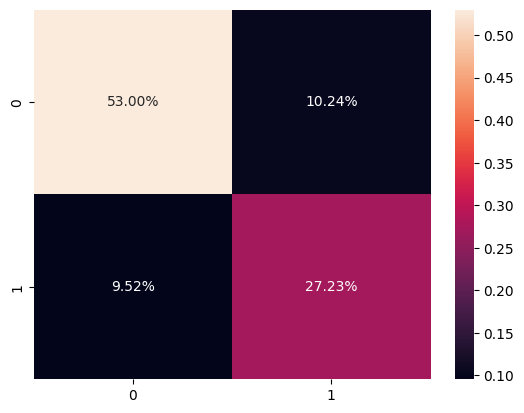

In [17]:

model_dtc = DecisionTreeClassifier()
model_dtc.fit(x_train, y_train)
y_pred_dtc = model_dtc.predict(x_test)
acc_dtc = accuracy_score(y_test, y_pred_dtc)
print(f'Test Accuracy : {acc_dtc*100:.2f}%')
print(model_metrics(y_test, y_pred_dtc))
cf_matrix_dtc = confusion_matrix(y_test, y_pred_dtc)
sns.heatmap(cf_matrix_dtc/np.sum(cf_matrix_dtc), annot=True, fmt= '0.2%')


Test Accuracy : 84.49%
   precision  f1-score  recall  sensitivity  specificity
0       0.92      0.88    0.85         0.87         0.11
1       0.71      0.77    0.84         0.80         0.19


,Feature Importance
lead_time,0.260322
adr,0.200390
arrival_date_week_number,0.120376
stays_in_weekend_nights,0.118189
total_of_special_requests,0.078303
stays_in_week_nights,0.061112
previous_cancellations,0.057056
booking_changes,0.037811
required_car_parking_spaces,0.027697
adults,0.021218


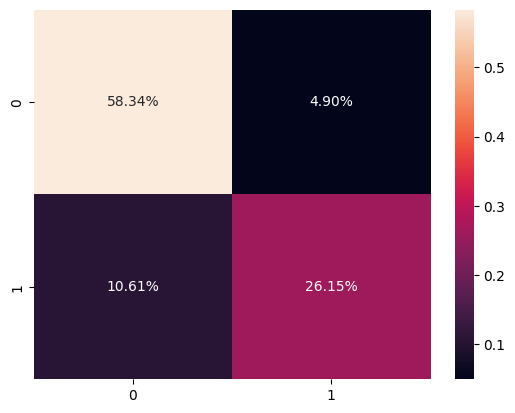

In [18]:

model_rfc = RandomForestClassifier()
model_rfc.fit(x_train, y_train)
pred_rfc = model_rfc.predict(x_test)
acc_rfc = accuracy_score(pred_rfc, y_test)
print(f'Test Accuracy : {acc_rfc*100:.2f}%')
print(model_metrics(pred_rfc, y_test))
cf_matrix_rfc = confusion_matrix(y_test, pred_rfc)
sns.heatmap(cf_matrix_rfc/np.sum(cf_matrix_rfc), annot=True,fmt= '0.2%')

fs = pd.DataFrame(index=x.columns, data=model_rfc.feature_importances_, columns=['Feature Importance'])
sorted_fs = fs.sort_values(by='Feature Importance', ascending= False)
sorted_fs

Test Accuracy : 76.71%
   precision  f1-score  recall  sensitivity  specificity
0       0.85      0.82    0.79         0.81         0.15
1       0.62      0.66    0.71         0.69         0.25


<Axes: >

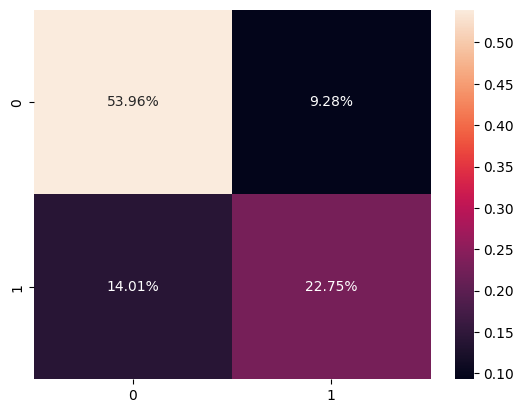

In [19]:
model_knn = KNeighborsClassifier()
model_knn.fit(x_train, y_train)
pred_knn = model_knn.predict(x_test)
acc_knn = accuracy_score(y_test, pred_knn)
print(f'Test Accuracy : {acc_knn*100:.2f}%')
print(model_metrics(pred_knn, y_test))
cf_matrix_knn = confusion_matrix(y_test, pred_knn)
sns.heatmap(cf_matrix_knn/np.sum(cf_matrix_knn), annot=True,fmt= '0.2%')

In [20]:
output = pd.DataFrame({"Model":['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest'],
                      "Accuracy":[acc_log, acc_knn, acc_dtc, acc_rfc]})
output

,Model,Accuracy
0,Logistic Regression,0.734902
1,KNN,0.767108
2,Decision Tree,0.802329
3,Random Forest,0.844878


In [21]:
px.bar(output, x='Model', y='Accuracy', title='Comparision of various models')

Our analysis shows that the Random Forest Classifier performed the best in terms of accuracy compared to all other classifiers. Given that Random Forest is an ensemble of decision trees, each tree was constructed using a unique set of features and data samples.